# Configs

In [1]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.task_utils.config_parser import ConfigParser
configs_dict = {
    "task": "train",  # 'train', 'evaluate' or 'sweep'
    "data_configs": {
        "train_path": "../datasets/utn_dataset_curated/part2/train",
        "val_path": "../datasets/utn_dataset_curated/part2/val",
        "test_path": "../datasets/utn_dataset_curated/part2/test",
        "preprocessing_related": {
            "mean": 0.5,  # for raw_image normalisation
            "std": 0.5,  # for raw_image normalisation
            "downscale_factor": 4,
        },
        "dataset_related": {
            "train_preprocessed_dir": "../datasets/utn_dataset_curated/part2/train/images/",
            "val_preprocessed_dir": "../datasets/utn_dataset_curated/part2/val/images",
            "test_preprocessed_dir": "../datasets/utn_dataset_curated/part2/test/images",
            "train_labels_dir": "../datasets/utn_dataset_curated/part2/train/labels",
            "val_labels_dir": "../datasets/utn_dataset_curated/part2/val/labels",
            "augment": True,
            "shuffle": False,
        },
        "augmentation_related": {
            "flip_prob": 0,
            "zoom_prob": 0,
            "rotation_prob": 0,
            "line_prob": 0,
            "salt_pepper_prob": 1,
        },
    },
    "model_configs": {
        "name": "ssd_mnist",  # "ssd_mnist" or "ssd_captcha"
        "save_checkpoint": False,
        "log_gradients": False,
        "checkpoint": None,  # Training from Scratch
        "print_freq": 500,
        "epochs": 10,
        "batch_size": 2,
        "device": "cuda",  # either "cpu" or "cuda"
        "backbone": {
            "name": "VGG16",
            "num_stages": 6,
        },
        "loss": {
            "alpha": 0.25,  # loss = alpha*loc_loss + cls_loss
            "pos_box_threshold": 0.5,  # a default box is marked positive if it has (> pos_box_threshold) IoU score with any of the groundtruth boxes
            "hard_neg_pos": 3,  # num of negative boxes = hard_neg_pos * num_positive_boxes
        },
        "optim": {
            "name": "SGD",
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
            "clip_grad": None,
        },
        "scheduler": {
            "name": "LinearLR",  # 'MultiStepLR' or 'LinearLR'
            "milestones": [10, 20],  # lr reduction whenever training hits the given epoch milestone
            "gamma": 0.1,  # the factor by which the learning rate decreases
            "start_factor": 0.5,  # lr multiplicative factor increases from (start_factor to 1) in total_iter steps
            "total_iter": 4,
        },
    },
    "task_configs": {
        "img_height": 160,  # original image height
        "img_width": 640,  # original image width
        "debug": True,  # if True will display a lot of intermediate information for debugging purposes
        "log_expt": False,  # whether to log the experiment online or not
        "num_classes": 37,  # A-Z(26), 0-9(10), background(1)
        "min_cls_score": 0.01,  # if the cls score for a bounding box is less than this, it is considered as background
        "nms_iou_score": 0.1,  # if the iou between two bounding boxes is less than this, it is suppressed
    },
}

# hyperparameters
preprocessed_dir = "../datasets/utn_dataset_curated/part2/train/preprocessed"
labels_dir = "../datasets/utn_dataset_curated/part2/train/labels"

# Imports

In [2]:
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [3]:
config = ConfigParser(configs_dict).get_parser()
print(config.__dict__)  # Check all attributes in config

# this object can be used as follows:
print(f"{config.pos_box_threshold = }")

config = {'task': 'train', 'data_configs': {'train_path': '../datasets/utn_dataset_curated/part2/train', 'val_path': '../datasets/utn_dataset_curated/part2/val', 'test_path': '../datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'train_preprocessed_dir': '../datasets/utn_dataset_curated/part2/train/images/', 'val_preprocessed_dir': '../datasets/utn_dataset_curated/part2/val/images', 'test_preprocessed_dir': '../datasets/utn_dataset_curated/part2/test/images', 'train_labels_dir': '../datasets/utn_dataset_curated/part2/train/labels', 'val_labels_dir': '../datasets/utn_dataset_curated/part2/val/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0, 'zoom_prob': 0, 'rotation_prob': 0, 'line_prob': 0, 'salt_pepper_prob': 1}}, 'model_configs': {'name': 'ssd_mnist', 'save_checkpoint': False, 'log_gradients': False, 'checkpoint': None, 'print_freq': 500, 'epochs': 10, 'batch_si

In [4]:
# note: change to relative import using a dot (.) in datautils line 4 & 5

# 0. Dataloader

In [4]:
#print(sys.path)
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.preprocessing import get_img_transform, get_rectangle_img_transform
from src_code.data_utils.augmentation import Augmentations
# if the preprocessed dataset is not available, run create it using src_code/data_utils/preprocessing.py

current_path = os.getcwd()
print(current_path)

# Create dataset
dataset = CaptchaDataset(config.train_preprocessed_dir, config.train_labels_dir, augment=True, config=config, img_transform=get_rectangle_img_transform(config))

# Load a sample
image, bboxes, labels = dataset[0]

print("Image Shape:", image.size)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


# Create DataLoader
dataloader = get_dataloader(dataset, config)

# Load a single batch
images, bboxes, labels = next(iter(dataloader))

# Print batch info
print(f"Batch Image Shape: {images.shape}")
print(f"Bounding Boxes (First Image): {bboxes[0]}")
print(f"Labels (First Image): {labels[0]}")


/Users/lucaheller/Desktop/UTN_Captcha_Detector/notebooks
Image Shape: <built-in method size of Tensor object at 0x15d494bf0>
Bounding Boxes: tensor([[0.1430, 0.4818, 0.2001, 0.8585],
        [0.3307, 0.0000, 0.4611, 0.5103],
        [0.4181, 0.2645, 0.5456, 0.7704],
        [0.7742, 0.3091, 0.8777, 0.8153]])
Labels: tensor([21,  3, 24,  4])
Batch Image Shape: torch.Size([2, 1, 40, 160])
Bounding Boxes (First Image): tensor([[0.1430, 0.4818, 0.2001, 0.8585],
        [0.3307, 0.0000, 0.4611, 0.5103],
        [0.4181, 0.2645, 0.5456, 0.7704],
        [0.7742, 0.3091, 0.8777, 0.8153]])
Labels (First Image): tensor([21,  3, 24,  4])


BBoxes for Visualization: tensor([[ 22,  19,  32,  34],
        [ 52,   0,  73,  20],
        [ 66,  10,  87,  30],
        [123,  12, 140,  32]], dtype=torch.int32)


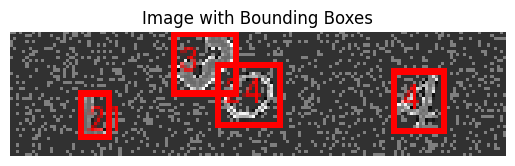

In [ ]:
# Load one sample for visualization
image, bboxes, labels = dataset[0]

#print("Image Shape:", image.shape)
#print("Bounding Boxes:", bboxes)
#print("Labels:", labels)


def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[-2], image.shape[-1] 
    
    # Scale normalized bboxes to absolute pixel values for visualization
    bboxes[:, [0, 2]] *= img_width
    bboxes[:, [1, 3]] *= img_height

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    print("BBoxes for Visualization:", bboxes_abs)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [str(l) for l in labels]

    # Draw bboxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=2)

    # image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_image_with_bboxes(image, bboxes, labels)
